# **Cell 0 — (Optional) set GPU runtime**

In [ ]:
from google.colab import drive
import os, shutil

drive.mount('/content/drive')

file_name = "ztf_single4_frcnn.zip"
src = f"/content/drive/MyDrive/{file_name}"
zip_path = f"/content/{file_name}"

if not os.path.exists(src):
    raise FileNotFoundError(f"Zip not found: {src}")

shutil.copy(src, zip_path)
print("✅ Copied zip to:", zip_path)


Mounted at /content/drive
✅ Copied zip to: /content/ztf_single4_frcnn.zip


# **Cell 2 — Extract zip to a clean folder**

In [ ]:
import os, zipfile, shutil

zip_path = "/content/ztf_single4_frcnn.zip"
extract_dir = "/content/ztf_extracted"

if os.path.isdir(extract_dir):
    shutil.rmtree(extract_dir)
os.makedirs(extract_dir, exist_ok=True)

print("Extracting...")
with zipfile.ZipFile(zip_path, "r") as z:
    z.extractall(extract_dir)
print("✅ Extracted to:", extract_dir)

print("\nTop-level:")
for x in sorted(os.listdir(extract_dir))[:50]:
    print(" -", x)


Extracting...
✅ Extracted to: /content/ztf_extracted

Top-level:
 - __MACOSX
 - ztf_single4_frcnn


# **Cell 3 — Auto-find the dataset root (YOLO root)**

In [ ]:
import os, glob

def guess_yolo_root(root):
    candidates = []
    for d in glob.glob(os.path.join(root, "**"), recursive=True):
        if not os.path.isdir(d):
            continue
        if os.path.isdir(os.path.join(d,"images","train")) and os.path.isdir(os.path.join(d,"labels","train")):
            candidates.append(d)
    candidates = sorted(candidates, key=lambda x: len(x))
    return candidates[0] if candidates else None

SOURCE_ROOT = guess_yolo_root("/content/ztf_extracted")
if not SOURCE_ROOT:
    raise RuntimeError("❌ Could not find YOLO root with images/train + labels/train inside extracted folder.")

print("✅ SOURCE_ROOT =", SOURCE_ROOT)

# quick counts
for sp in ["train","val","test"]:
    ip = os.path.join(SOURCE_ROOT,"images",sp)
    lp = os.path.join(SOURCE_ROOT,"labels",sp)
    if os.path.isdir(ip):
        nimg = len(glob.glob(os.path.join(ip,"**","*.*"), recursive=True))
        print(f"{sp:5s} images dir:", ip)
    if os.path.isdir(lp):
        ntxt = len(glob.glob(os.path.join(lp,"**","*.txt"), recursive=True))
        print(f"{sp:5s} labels count:", ntxt)


✅ SOURCE_ROOT = /content/ztf_extracted/ztf_single4_frcnn
train images dir: /content/ztf_extracted/ztf_single4_frcnn/images/train
train labels count: 2660
val   images dir: /content/ztf_extracted/ztf_single4_frcnn/images/val
val   labels count: 856


# **Cell 4 — Confirm we’re using the right target class id (fixed)**

In [ ]:
TARGET_IDS = [2]  # target class id(s) in original dataset
print("Using TARGET_IDS =", TARGET_IDS)


Using TARGET_IDS = [2]


# **Cell 5 — Build “Class2-only” dataset (1 class) into /content/ztf_class2_1class**

In [ ]:
import os, glob, shutil

TARGET_ROOT = "/content/ztf_class2_1class"
KEEP_NEGATIVES = True

IMG_EXTS = (".jpg",".jpeg",".png",".bmp",".webp",".tif",".tiff")

def ensure_dir(p): os.makedirs(p, exist_ok=True)

def list_images(img_dir):
    out=[]
    for e in IMG_EXTS:
        out += glob.glob(os.path.join(img_dir, "**", f"*{e}"), recursive=True)
    return sorted(set(out))

def copy_file(src, dst):
    ensure_dir(os.path.dirname(dst))
    if not os.path.exists(dst):
        shutil.copy2(src, dst)

def filter_labels_to_ids(label_src, label_dst, keep_ids):
    ensure_dir(os.path.dirname(label_dst))
    kept=[]
    if os.path.isfile(label_src):
        with open(label_src, "r") as f:
            for line in f:
                line=line.strip()
                if not line:
                    continue
                parts=line.split()
                if len(parts) != 5:
                    continue
                cls = int(float(parts[0]))
                if cls in keep_ids:
                    parts[0] = "0"   # remap SN -> 0
                    kept.append(" ".join(parts))
    # write label (empty ok for negatives)
    with open(label_dst, "w") as f:
        if kept:
            f.write("\n".join(kept) + "\n")
    return len(kept)

# clean target
if os.path.isdir(TARGET_ROOT):
    shutil.rmtree(TARGET_ROOT)
ensure_dir(TARGET_ROOT)

splits = [sp for sp in ["train","val","test"] if os.path.isdir(os.path.join(SOURCE_ROOT,"images",sp))]
print("Splits found:", splits)

stats = {}
total_imgs = total_pos = total_neg = total_boxes = 0
keep_ids = set(TARGET_IDS)

for sp in splits:
    src_img_dir = os.path.join(SOURCE_ROOT, "images", sp)
    src_lbl_dir = os.path.join(SOURCE_ROOT, "labels", sp)

    dst_img_dir = os.path.join(TARGET_ROOT, "images", sp)
    dst_lbl_dir = os.path.join(TARGET_ROOT, "labels", sp)
    ensure_dir(dst_img_dir); ensure_dir(dst_lbl_dir)

    imgs = list_images(src_img_dir)

    kept_imgs = pos_imgs = neg_imgs = boxes_kept = 0

    for img_path in imgs:
        rel = os.path.relpath(img_path, src_img_dir).replace("\\","/")
        stem = os.path.splitext(rel)[0]
        lbl_src = os.path.join(src_lbl_dir, stem + ".txt")
        lbl_dst = os.path.join(dst_lbl_dir, stem + ".txt")

        k = filter_labels_to_ids(lbl_src, lbl_dst, keep_ids)

        if (not KEEP_NEGATIVES) and (k == 0):
            if os.path.isfile(lbl_dst):
                os.remove(lbl_dst)
            continue

        img_dst = os.path.join(dst_img_dir, rel)
        copy_file(img_path, img_dst)

        kept_imgs += 1
        boxes_kept += k
        if k > 0: pos_imgs += 1
        else:     neg_imgs += 1

    stats[sp] = dict(images=kept_imgs, pos_images=pos_imgs, neg_images=neg_imgs, sn_boxes=boxes_kept)
    total_imgs += kept_imgs
    total_pos  += pos_imgs
    total_neg  += neg_imgs
    total_boxes += boxes_kept

print("\n=== SN-ONLY DATASET STATS ===")
for sp in stats:
    print(sp, stats[sp])

print("\nTotals:", "images=", total_imgs, "pos_images=", total_pos, "neg_images=", total_neg, "sn_boxes=", total_boxes)

if total_pos == 0:
    raise RuntimeError("❌ ZERO positives after filtering. That would mean TARGET_IDS is wrong (but in your case it’s correct).")


Splits found: ['train', 'val']

=== SN-ONLY DATASET STATS ===
train {'images': 2660, 'pos_images': 2660, 'neg_images': 0, 'sn_boxes': 2660}
val {'images': 856, 'pos_images': 856, 'neg_images': 0, 'sn_boxes': 856}

Totals: images= 3516 pos_images= 3516 neg_images= 0 sn_boxes= 3516


# **Cell 6 — Write YOLOv8 data.yaml (1 class)**

In [ ]:
import os, yaml

data_yaml = {
    "path": TARGET_ROOT,
    "train": "images/train",
    "val": "images/val",
    "names": ["class2"],
    "nc": 1
}
if os.path.isdir(os.path.join(TARGET_ROOT, "images", "test")):
    data_yaml["test"] = "images/test"

yaml_path = os.path.join(TARGET_ROOT, "data.yaml")
with open(yaml_path, "w") as f:
    yaml.safe_dump(data_yaml, f, sort_keys=False)

print("✅ data.yaml:", yaml_path)
print(open(yaml_path).read())


✅ data.yaml: /content/ztf_class2_1class/data.yaml
path: /content/ztf_class2_1class
train: images/train
val: images/val
names:
- class2
nc: 1



# **Cell 7 — Install Ultralytics YOLOv8**

In [ ]:
!pip -q install ultralytics pyyaml
from ultralytics import YOLO


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.3 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# **Cell 8 — Train YOLOv8 (astro-friendly aug settings)**

In [ ]:
model = YOLO("yolov8s.pt")  # change to yolov8m.pt if you want stronger

results = model.train(
    data=yaml_path,
    epochs=120,
    imgsz=320,
    batch=32,
    device=0,
    workers=2,
    project="/content/runs_ztf_cls2",
    name="yolov8_class2_only",
    patience=30,
    seed=42,

    # reduce junk augmentations for grayscale astro cutouts
    hsv_h=0.0, hsv_s=0.0, hsv_v=0.0,
    fliplr=0.0, flipud=0.0,

    # mosaic can hurt tiny targets in astro; keep off
    mosaic=0.0,
    close_mosaic=0
)

print("✅ Training finished.")

Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=0, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/ztf_class2_1class/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=120, erasing=0.4, exist_ok=False, fliplr=0.0, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.0, hsv_s=0.0, hsv_v=0.0, imgsz=320, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=0.0, multi_scale=False, name=yolov8_class2_only, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=30, perspective=0.0, plo

In [ ]:
import os, glob, yaml

root = SOURCE_ROOT
cands = []
for pat in ["**/data.yaml","**/dataset.yaml","**/*.names","**/classes.txt","**/names.txt","**/obj.names"]:
    cands += glob.glob(os.path.join(root, pat), recursive=True)

print("Found mapping candidates:")
for p in cands:
    print("-", p)

# If a yaml exists, print its names
for p in cands:
    if p.endswith((".yaml",".yml")):
        y = yaml.safe_load(open(p))
        print("\nYAML:", p)
        print("names:", y.get("names"))
        print("nc:", y.get("nc"))
        break


Found mapping candidates:


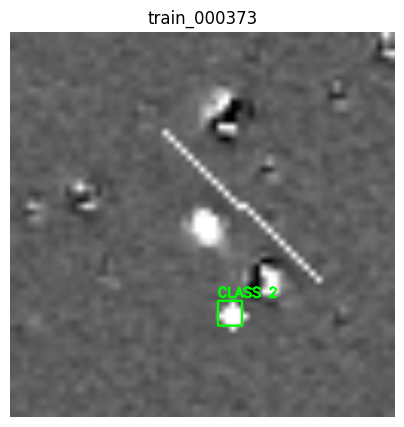

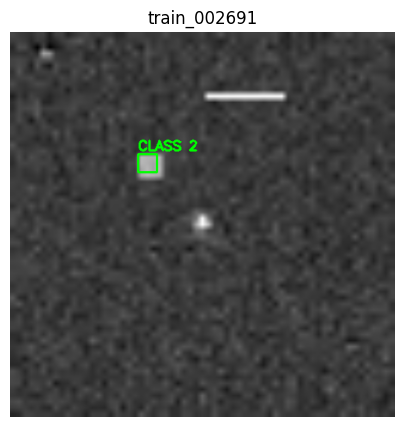

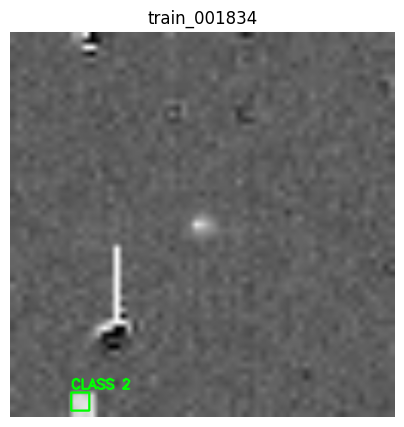

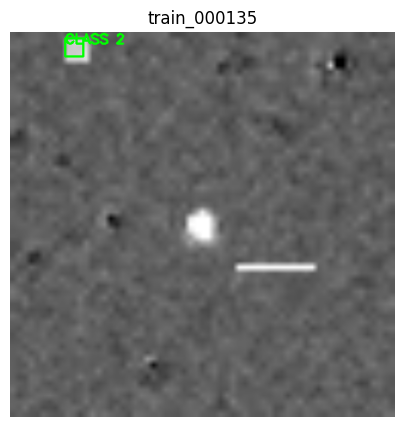

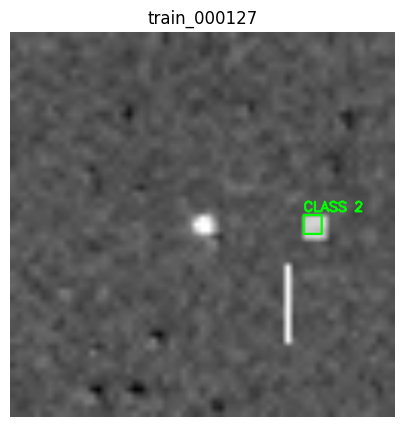

In [ ]:
import os, glob, random, cv2
import matplotlib.pyplot as plt

img_dir = os.path.join(SOURCE_ROOT, "images", "train")
lbl_dir = os.path.join(SOURCE_ROOT, "labels", "train")
imgs = sorted(glob.glob(img_dir + "/*.*"))

def draw_one():
    img_path = random.choice(imgs)
    stem = os.path.splitext(os.path.basename(img_path))[0]
    lbl_path = os.path.join(lbl_dir, stem + ".txt")

    img = cv2.imread(img_path)
    h, w = img.shape[:2]

    def yolo_to_xyxy(xc,yc,bw,bh):
        x1 = int((xc - bw/2) * w); y1 = int((yc - bh/2) * h)
        x2 = int((xc + bw/2) * w); y2 = int((yc + bh/2) * h)
        return x1,y1,x2,y2

    for line in open(lbl_path):
        p = line.split()
        if not p:
            continue
        cls = int(float(p[0]))
        xc,yc,bw,bh = map(float, p[1:])
        if cls == 2:
            x1,y1,x2,y2 = yolo_to_xyxy(xc,yc,bw,bh)
            cv2.rectangle(img,(x1,y1),(x2,y2),(0,255,0),2)
            cv2.putText(img,"CLASS 2",(x1,max(15,y1-5)),cv2.FONT_HERSHEY_SIMPLEX,0.6,(0,255,0),2)

    plt.figure(figsize=(5,5))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title(stem)
    plt.show()

for _ in range(5):
    draw_one()


In [ ]:
import os, glob, yaml

SEARCH_ROOTS = [
    "/content/ztf_extracted",                 # where you extracted the zip
    "/content/drive/MyDrive",                 # in case yaml is on Drive
]

def find_names_yaml(root):
    ymls = glob.glob(os.path.join(root, "**", "*.yaml"), recursive=True) + \
           glob.glob(os.path.join(root, "**", "*.yml"), recursive=True)
    ymls = sorted(set(ymls))
    print(f"Scanning {root} ... found {len(ymls)} yaml/yml files")

    for yp in ymls:
        try:
            d = yaml.safe_load(open(yp, "r"))
        except Exception:
            continue
        if isinstance(d, dict) and "names" in d and isinstance(d["names"], (list, dict)):
            return yp, d["names"]
    return None, None

for root in SEARCH_ROOTS:
    yp, names = find_names_yaml(root)
    if yp:
        print("\n✅ Found class names YAML:", yp)
        if isinstance(names, dict):
            # dict style: {0:'a',1:'b',...}
            names_list = [names[k] for k in sorted(names.keys())]
        else:
            names_list = list(names)
        print("names:", list(enumerate(names_list)))
        print("➡️ Class 2 name =", names_list[2] if len(names_list) > 2 else "MISSING")
        break
else:
    print("\n❌ No YAML with 'names:' was found. That means you CANNOT recover the real class names automatically.")
    print("You must provide the mapping yourself (from whoever built the dataset / your labeling script).")


Scanning /content/ztf_extracted ... found 0 yaml/yml files


KeyboardInterrupt: 

In [ ]:
from ultralytics import YOLO
model = YOLO("/content/runs_ztf_cls2/yolov8_class2_only/weights/best.pt")

REAL_NAME = "PUT_THE_REAL_NAME_HERE"  # you decide it based on your dataset definition
model.model.names = {0: REAL_NAME}


In [ ]:
import os
YAML_PATH="/content/ztf_class2_1class/data.yaml"
print("exists?", os.path.exists(YAML_PATH), "->", YAML_PATH)
!ls -la /content/ztf_class2_1class
!ls -la /content/ztf_class2_1class/data.yaml


exists? True -> /content/ztf_class2_1class/data.yaml
total 20
drwxr-xr-x 4 root root 4096 Dec 28 15:19 .
drwxr-xr-x 1 root root 4096 Dec 28 15:20 ..
-rw-r--r-- 1 root root   91 Dec 28 15:19 data.yaml
drwxr-xr-x 4 root root 4096 Dec 28 15:19 images
drwxr-xr-x 4 root root 4096 Dec 28 15:20 labels
-rw-r--r-- 1 root root 91 Dec 28 15:19 /content/ztf_class2_1class/data.yaml


In [ ]:
import yaml
p="/content/ztf_class2_1class/data.yaml"
d=yaml.safe_load(open(p))
d["names"]=["asteroid"]  # put whatever you decide
yaml.safe_dump(d, open(p,"w"), sort_keys=False)
print(open(p).read())


path: /content/ztf_class2_1class
train: images/train
val: images/val
names:
- asteroid
nc: 1



In [ ]:
import yaml
print(open("/content/ztf_class2_1class/data.yaml").read())


path: /content/ztf_class2_1class
train: images/train
val: images/val
names:
- PUT_REAL_NAME_HERE
nc: 1



In [ ]:
import glob, yaml, os

ORIG_ROOT = "/content/ztf_extracted/ztf_single4_frcnn"

yamls = glob.glob(f"{ORIG_ROOT}/**/*.yaml", recursive=True) + glob.glob(f"{ORIG_ROOT}/**/*.yml", recursive=True)
print("Found yamls:", len(yamls))
for p in yamls:
    try:
        d = yaml.safe_load(open(p))
        if isinstance(d, dict) and "names" in d:
            print("\n✅ names found in:", p)
            print("names =", d["names"])
            print("class 2 =", d["names"][2])
            break
    except:
        pass


Found yamls: 0


In [ ]:
import yaml
p="/content/ztf_class2_1class/data.yaml"
d=yaml.safe_load(open(p))
d["names"]=["asteroid"]  # put whatever you decide
yaml.safe_dump(d, open(p,"w"), sort_keys=False)
print(open(p).read())


path: /content/ztf_class2_1class
train: images/train
val: images/val
names:
- asteroid
nc: 1



In [ ]:
from ultralytics import YOLO
import os

YAML_PATH = "/content/ztf_class2_1class/data.yaml"
BEST_PT   = "/content/runs_ztf_cls2/yolov8_class2_only/weights/best.pt"

assert os.path.exists(YAML_PATH), "YAML missing"
assert os.path.exists(BEST_PT), "best.pt missing"

model = YOLO(BEST_PT)

metrics = model.val(
    data=YAML_PATH,
    imgsz=320,
    conf=0.001,
    iou=0.7,
    plots=True,          # ✅ this is what generates curves + confusion matrix
    project="/content/runs_ztf_cls",
    name="val_best_plots",
)
print("Saved to:", metrics.save_dir)


AssertionError: best.pt missing

In [ ]:
#for cpu
from ultralytics import YOLO

model = YOLO(" /content/yolov8_class2_only.pt")

model.predict(
    source="/content/ztf_class2_1class/images/val",
    imgsz=320,
    conf=0.25,
    device="cpu",      # ✅ force CPU
    save=True,
    save_txt=True,
    save_conf=True,
    project="/content/runs_cpu4",
    name="pred_cpu"
)


In [ ]:
from ultralytics import YOLO

model = YOLO("/content/yolov8_class2_only.pt")
model.model.names = {0: "asteroid"}   # force label text

model.predict(source="/content/ztf_class2_1class/images/val", conf=0.25, save=True, save_conf=True)


In [ ]:
import glob, yaml, os

# find any data*.yaml that looks like the original (nc=4)
cands = sorted(glob.glob("/content/**/data*.yaml", recursive=True))

found = []
for p in cands:
    try:
        d = yaml.safe_load(open(p, "r"))
        if isinstance(d, dict) and d.get("nc") == 4 and "names" in d:
            found.append((p, d["names"]))
    except:
        pass

print("FOUND:", len(found))
for p, names in found:
    print("\nYAML:", p)
    print("names:", names)
    print("class 2 =", names[2])


FOUND: 0


In [ ]:
from ultralytics import YOLO

model = YOLO("/content/runs_ztf_cls2/yolov8_class2_only/weights/best.pt")

model.val(
    data="/content/ztf_class2_1class/data.yaml",
    imgsz=320,
    conf=0.001,
    iou=0.7,
    device="cpu",      # ✅ force CPU
    plots=True,
    project="/content/runs_cpu",
    name="val_cpu_plots"
)


In [ ]:
import yaml
from ultralytics import YOLO

yaml_path = "/content/ztf_class2_1class/data.yaml"
best_pt   = "/content/yolov8_class2_only.pt"

# 1) Update YAML names
d = yaml.safe_load(open(yaml_path))
d["nc"] = 1
d["names"] = ["asteroid"]   # <-- put your final name here
yaml.safe_dump(d, open(yaml_path, "w"), sort_keys=False)

# 2) Load model and FORCE names (important because ckpt may still hold class2)
model = YOLO(best_pt)
model.model.names = {0: "asteroid"}

# 3) Re-run validation to regenerate curves + confusion matrix
model.val(
    data=yaml_path,
    plots=True,
    project="/content/runs_ztf_cls2",
    name="yolov8_class2_only_renamed",
    device="cpu"   # CPU is fine for val/plots
)
